In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from scipy.integrate import solve_ivp
from mpl_toolkits.mplot3d import Axes3D
from copy import deepcopy
import pandas as pd
import itertools
from sklearn.linear_model import LinearRegression

## Linear Damped Simple Harmonic Oscillator

### Simple illustrative systems
Here we give examples of SINDy applied to simple linear and nonlinear dynamical systems. In each instance the `SINDy` object is given measurements of state variables, but not their derivatives, and is tasked with identifying the equations to describe their dynamics.

### Linear 2D ODE

The first example shows a demonstration of SINDy on a linear two-dimensional damped harmonic oscillator.

We generate training data by integrating the following linear system of differential equations with initial condtion $(2,0)$.

$$ \frac{d}{dt} \begin{bmatrix}x \\ y\end{bmatrix} = \begin{bmatrix} -0.1 & 2 \\ -2 & -0.1 \end{bmatrix} \begin{bmatrix}x \\ y\end{bmatrix} $$

In [3]:
def linear_damped_SHO(t, x):
    return [-0.1 * x[0] + 2 * x[1], -2 * x[0] - 0.1 * x[1]]

def linear_damped_SHO_temp(x, t):
    return -0.1*x[0]+2*x[1], -2*x[0]-0.1*x[1]

In [4]:
#generate training data
dt = 0.01
t_train = np.arange(0, 25, dt)
t_train_span = (t_train[0], t_train[-1])

x0_train = [2, 0]

# Integrator keywords for solve_ivp
integrator_keywords = {}
integrator_keywords['rtol'] = 1e-12
integrator_keywords['method'] = 'LSODA'
integrator_keywords['atol'] = 1e-12
x_train = solve_ivp(linear_damped_SHO, t_train_span, 
                    x0_train, t_eval=t_train, **integrator_keywords).y.T

X_train_odeint = odeint(linear_damped_SHO_temp, x0_train, t_train)
X_train_odeint

array([[ 2.        ,  0.        ],
       [ 1.99760142, -0.03995734],
       [ 1.99440741, -0.07981886],
       ...,
       [ 0.15601804,  0.05265377],
       [ 0.15688288,  0.04947359],
       [ 0.15768315,  0.04627994]])

In [5]:
# Finds combination of input variables for n-dimensional polynomial library with degree=[1-k]
# generates degree-dimensional volume which have n discrete points on each dimension
# algorithm traverse points which are on/below diagnol

def polynomial_library_Combination_generator(X, degree=2):
    
    polynomial_set=[]
    indexes_variables = [[i] for i in range(X.shape[1])]
    polynomial_set.append(indexes_variables)

    for i in range(1,degree):
        polynomial_degree_i_set=[]
        next_branches_set=deepcopy(polynomial_set[i-1])
        for j in range(len(next_branches_set)):
            new_set_for_branch_j=[]
            for k in range(degree+1):
                if k > next_branches_set[j][len(next_branches_set[j])-1]:
                    break
                new_instance=deepcopy(next_branches_set[j])
                new_instance.append(k)
                new_set_for_branch_j.append(new_instance)

            for set in new_set_for_branch_j:
                polynomial_degree_i_set.append(set)
        
        
        polynomial_set.append(polynomial_degree_i_set)
    return polynomial_set


In [6]:
polynomial_degree=4
combinations = polynomial_library_Combination_generator(X_train_odeint, polynomial_degree)
combinations

[[[0], [1]],
 [[0, 0], [1, 0], [1, 1]],
 [[0, 0, 0], [1, 0, 0], [1, 1, 0], [1, 1, 1]],
 [[0, 0, 0, 0], [1, 0, 0, 0], [1, 1, 0, 0], [1, 1, 1, 0], [1, 1, 1, 1]]]

In [7]:
# Generate Theta Polynomial library
def generator_Polynomial_library_theta(combinations_Set, X, dict_index_To_colName):
    theta_library_list=[]
    for i in range(len(X)):
        temp_row = list(deepcopy(X[i]))
        for deg in combinations_Set[1:]:
            for comb in deg:
                value=1
                for index_col in comb:
                    value*=X[i][index_col]
                temp_row.append(value)
        theta_library_list.append(temp_row)


    if len(dict_index_To_colName) == len(X[0]):
        column_name_list=[]
        for deg in combinations_Set:
            for comb in deg:
                col_name=""
                for index_col in comb:
                    col_name+=dict_index_To_colName[index_col]
                column_name_list.append(col_name)
        Theta_df = pd.DataFrame(theta_library_list, columns=column_name_list)
    else:
        Theta_df = pd.DataFrame(theta_library_list)
    return Theta_df

In [8]:
index_To_colName={0:'x',1:'y'}
Theta_lib = generator_Polynomial_library_theta(combinations, X_train_odeint, index_To_colName)
Theta_lib[:5]

,x,y,xx,yx,yy,xxx,yxx,yyx,yyy,xxxx,yxxx,yyxx,yyyx,yyyy
0,2.000000,0.000000,4.000000,0.000000,0.000000,8.000000,0.000000,0.000000,0.000000,16.000000,0.000000,0.000000,0.000000,0.000000
1,1.997601,-0.039957,3.990411,-0.079819,0.001597,7.971251,-0.159446,0.003189,-0.000064,15.923383,-0.318510,0.006371,-0.000127,0.000003
2,1.994407,-0.079819,3.977661,-0.159191,0.006371,7.933076,-0.317492,0.012706,-0.000509,15.821786,-0.633209,0.025342,-0.001014,0.000041
3,1.990421,-0.119569,3.961775,-0.237992,0.014297,7.885600,-0.473705,0.028456,-0.001709,15.695663,-0.942871,0.056640,-0.003402,0.000204
4,1.985645,-0.159191,3.942786,-0.316097,0.025342,7.828973,-0.627657,0.050320,-0.004034,15.545560,-1.246305,0.099918,-0.008011,0.000642


In [14]:
def STLSQ(Theta_df, X, X_dot, dict_index_To_colName, threshold = 0.01):
    max_iterations=100

    df_library_theta_02 = deepcopy(Theta_df)
    sol={}
    for col in range(X.shape[1]):
        print("Column:", (col))
        theta_lib = deepcopy(df_library_theta_02)        
        # selected_cols = 
        total_sel_cols = len(theta_lib.columns)
        for itration in range(max_iterations):
            reg = LinearRegression().fit(theta_lib.values.tolist(), X_dot[:, col])
            selected_cols = [\
                [index,val, theta_lib.columns[index]]\
                    for index,val in enumerate(reg.coef_)\
                        if abs(val) > threshold]

            if len(selected_cols) == total_sel_cols: # means no more filteration was done
                break
            print("iteration:",itration,"\tColumns Filtered:", total_sel_cols-len(selected_cols))
            total_sel_cols=len(selected_cols)

            # filter df using selected columns
            theta_lib = theta_lib.loc()[:,[x[2] for x in selected_cols]]
        if len(dict_index_To_colName) == len(X[0]):
            sol[dict_index_To_colName[col]] = selected_cols
        else:
            sol[col] = selected_cols

    return sol

### Computing Finite Differences

In [15]:
def FiniteDifference_Approximation(XT, timeTr, approxOrder=5,Compute_Boundaries=False, traverse=True):
    # Arguments: Compute_Boundaries and tranverse should not be used by user
    # Use newton forward difference approximation and omits approxOrder # of points form end
    # XT has number of array=len(timeTr) and each array has n instaces where n=number of variables 
    # following two loops concat all instances of 1 variable in each array
    # Assumption: delta-t remains same
    deltaT=timeTr[1]-timeTr[0]
    arr=[]
    for i in range(XT.shape[1]):
       arr.append([]) 
    for i in range(len(timeTr)):
        for j in range(XT.shape[1]):
            arr[j].append(XT[i][j])

    if Compute_Boundaries:
        for j in range(len(arr)):
            arr[j] = deepcopy(np.flip(arr[j]))

    
    drivative=[]
    for j in range(len(arr)):
        temp_deriv=np.diff(arr[j])
        ordersOfDeriv=[]

        for nth in range(1,approxOrder):
            curr_diff = np.diff(temp_deriv)
            ordersOfDeriv.append(temp_deriv[:-(approxOrder-nth)])
            temp_deriv=deepcopy(curr_diff)
        ordersOfDeriv.append(temp_deriv[:])

        result_deriv=ordersOfDeriv[0]
        for nth in range(1,approxOrder):
            result_deriv = result_deriv + ((-1) ** nth)*(1/(nth+1))*ordersOfDeriv[nth]
        result_deriv /= deltaT
        drivative.append(result_deriv)

    if traverse:
        __,tmp_dr = FiniteDifference_Approximation(XT[-(approxOrder*2):], timeTr[-(approxOrder*2):], approxOrder,True, False)
        for i in range(len(tmp_dr)):
            drivative[i]=np.concatenate((drivative[i],np.flip(tmp_dr[i])), axis=0)
    
    XDot=np.transpose(drivative)
    return XDot, drivative

In [16]:
XDot_Linear2d_Approx,__=FiniteDifference_Approximation(X_train_odeint, t_train,20)

In [17]:
solution_with_XDot_Approx=STLSQ(Theta_lib, X_train_odeint, XDot_Linear2d_Approx, index_To_colName)
solution_with_XDot_Approx

Column: 0
iteration: 0 	Columns Filtered: 12
Column: 1
iteration: 0 	Columns Filtered: 10
iteration: 1 	Columns Filtered: 2


{'x': [[0, -0.10081694695576554, 'x'], [1, 1.9993133096968978, 'y']],
 'y': [[0, -1.9981747033096733, 'x'], [1, -0.09855117570661531, 'y']]}

In [18]:
def print_Sol(sol, dict_index_To_colName):
    solution_detail={}
    for ind in (dict_index_To_colName):
        col_nm=dict_index_To_colName[ind]
        intitial_str= "d"+str(dict_index_To_colName[ind])+'/dt = '
        for xx in sol[col_nm]:
            intitial_str += '('+str(round(xx[1],3))+')'+"*"+xx[2] + '+'
        print(intitial_str[:-1])


In [19]:
print_Sol(solution_with_XDot_Approx,index_To_colName)


dx/dt = (-0.101)*x+(1.999)*y
dy/dt = (-1.998)*x+(-0.099)*y


In [20]:
def simulate_XdotApprox(state_given, t):
    x, y = state_given
    dxdt= -0.10081694695576554*x + 1.9993133096968978*y
    dydt= -1.9981747033096733*x -0.09855117570661531*y 
    return dxdt, dydt

initial_value=[2,0]
Xt_computed_XdotApprox_Sol = odeint(simulate_XdotApprox, initial_value, t_train[1:])

/tmp/ipykernel_31056/3486933908.py:17: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


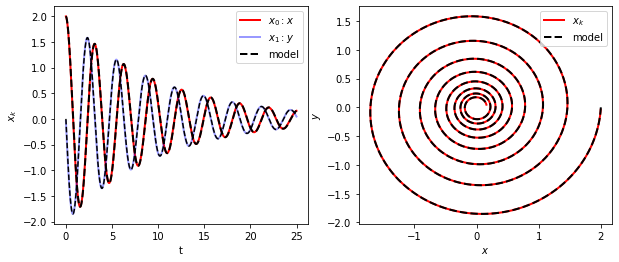

In [21]:
plot_kws = dict(linewidth=2)

fig, axs = plt.subplots(1, 2, figsize=(10, 4))
axs[0].plot(t_train[1:], X_train_odeint[1:, 0], "r", label="$x_0:x$", **plot_kws)
axs[0].plot(t_train[1:], X_train_odeint[1:, 1], "b", label="$x_1:y$", alpha=0.4, **plot_kws)
axs[0].plot(t_train[1:], Xt_computed_XdotApprox_Sol[:, 0], "k--", label="model", **plot_kws)
axs[0].plot(t_train[1:], Xt_computed_XdotApprox_Sol[:, 1], "k--")
axs[0].legend()
axs[0].set(xlabel="t", ylabel="$x_k$")

axs[1].plot(X_train_odeint[1:, 0], X_train_odeint[1:, 1], "r", label="$x_k$", **plot_kws)
axs[1].plot(Xt_computed_XdotApprox_Sol[:, 0], Xt_computed_XdotApprox_Sol[:, 1], "k--", label="model", **plot_kws)
axs[1].legend()
axs[1].set(xlabel="$x$", ylabel="$y$")


fig.show()

[Text(0.5, 0, '$t$'), Text(0.5, 0.5, '$x$'), Text(0.5, 0, '$y$')]

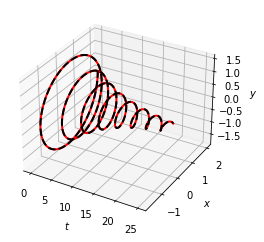

In [22]:
ax = plt.axes(projection='3d')
ax.plot(t_train[1:], X_train_odeint[1:, 0], X_train_odeint[1:, 1], "r", label="$x_k$", **plot_kws)
ax.plot(t_train[1:], Xt_computed_XdotApprox_Sol[:, 0], Xt_computed_XdotApprox_Sol[:, 1], "k--", label="model", **plot_kws)
ax.set(xlabel="$t$", ylabel="$x$", zlabel="$y$")

### Cubic 2D ODE

The first example shows a demonstration of SINDy on a linear two-dimensional damped harmonic oscillator.

We generate training data by integrating the following linear system of differential equations with initial condtion $(2,0)$.

$$ \frac{d}{dt} \begin{bmatrix}x \\ y\end{bmatrix} = \begin{bmatrix} -0.1 & 2 \\ -2 & -0.1 \end{bmatrix} \begin{bmatrix}x^3 \\ y^3\end{bmatrix} $$

In [23]:
def cubic_damped_SHO(t, x):
    return [-0.1 * (x[0] ** 3) + 2 * (x[1]** 3), -2 * (x[0]** 3) - 0.1 * (x[1]** 3)]

def cubic_damped_SHO_temp(x, t):
    return -0.1*(x[0]** 3)+2*(x[1]** 3), -2*(x[0]** 3)-0.1*(x[1]** 3)

In [24]:
Xt_train_cubic = odeint(cubic_damped_SHO_temp, x0_train, t_train)

In [33]:
polynomial_degree=4
combinations_cubic = polynomial_library_Combination_generator(Xt_train_cubic, polynomial_degree)
combinations_cubic

[[[0], [1]],
 [[0, 0], [1, 0], [1, 1]],
 [[0, 0, 0], [1, 0, 0], [1, 1, 0], [1, 1, 1]],
 [[0, 0, 0, 0], [1, 0, 0, 0], [1, 1, 0, 0], [1, 1, 1, 0], [1, 1, 1, 1]]]

In [34]:
index_To_colName={0:'x',1:'y'}
Theta_lib_cubic = generator_Polynomial_library_theta(combinations_cubic, Xt_train_cubic, index_To_colName)
Theta_lib_cubic[:5]

,x,y,xx,yx,yy,xxx,yxx,yyx,yyy,xxxx,yxxx,yyxx,yyyx,yyyy
0,2.000000,0.000000,4.000000,0.000000,0.000000,8.000000,0.000000,0.000000,0.000000,16.000000,0.000000,0.000000,0.000000,0.000000
1,1.992027,-0.159044,3.968173,-0.316821,0.025295,7.904711,-0.631116,0.050389,-0.004023,15.746401,-1.257200,0.100375,-0.008014,0.000640
2,1.983873,-0.316164,3.935750,-0.627230,0.099960,7.808027,-1.244344,0.198308,-0.031604,15.490131,-2.468620,0.393417,-0.062698,0.009992
3,1.974847,-0.471225,3.900020,-0.930598,0.222053,7.701943,-1.837789,0.438521,-0.104637,15.210158,-3.629351,0.866013,-0.206642,0.049308
4,1.963855,-0.623866,3.856728,-1.225184,0.389209,7.574057,-2.406084,0.764351,-0.242815,14.874353,-4.725200,1.501075,-0.476853,0.151484


In [37]:
XDot_Cubic2d_Approx,__=FiniteDifference_Approximation(Xt_train_cubic, t_train,20)

In [45]:
solution = STLSQ(Theta_lib_cubic, Xt_train_cubic, XDot_Cubic2d_Approx, index_To_colName)
solution

Column: 0
iteration: 0 	Columns Filtered: 12
Column: 1
iteration: 0 	Columns Filtered: 11
iteration: 1 	Columns Filtered: 1


{'x': [[0, -0.10008384867519914, 'xxx'], [1, 2.0000154408559854, 'yyy']],
 'y': [[0, -1.999679054065917, 'xxx'], [1, -0.10006129975575981, 'yyy']]}

In [46]:
print_Sol(solution,index_To_colName)

dx/dt = (-0.1)*xxx+(2.0)*yyy
dy/dt = (-2.0)*xxx+(-0.1)*yyy


In [47]:
def simulate_cubic_ode(state_given, t):
    x, y = state_given
    dxdt= -0.10008384867519914*(x ** 3) + 2.0000154408559854*(y ** 3)
    dydt= -1.999679054065917*(x ** 3) -0.10006129975575981*(y ** 3) 
    return dxdt, dydt

In [52]:
initial_value=[2,0]
Xt_Simulated_cubic = odeint(simulate_cubic_ode, initial_value, t_train)

/tmp/ipykernel_31056/1418623503.py:15: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


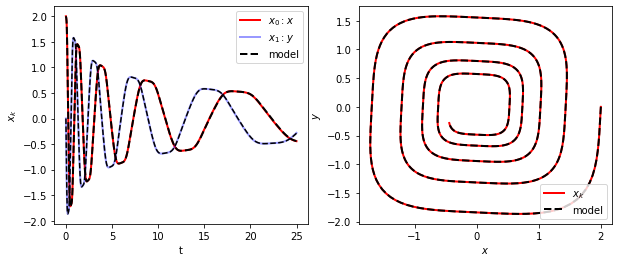

In [53]:
plot_kws = dict(linewidth=2)

fig, axs = plt.subplots(1, 2, figsize=(10, 4))
axs[0].plot(t_train, Xt_train_cubic[:, 0], "r", label="$x_0:x$", **plot_kws)
axs[0].plot(t_train, Xt_train_cubic[:, 1], "b", label="$x_1:y$", alpha=0.4, **plot_kws)
axs[0].plot(t_train, Xt_Simulated_cubic[:, 0], "k--", label="model", **plot_kws)
axs[0].plot(t_train, Xt_Simulated_cubic[:, 1], "k--")
axs[0].legend()
axs[0].set(xlabel="t", ylabel="$x_k$")

axs[1].plot(Xt_train_cubic[:, 0], Xt_train_cubic[:, 1], "r", label="$x_k$", **plot_kws)
axs[1].plot(Xt_Simulated_cubic[:, 0], Xt_Simulated_cubic[:, 1], "k--", label="model", **plot_kws)
axs[1].legend()
axs[1].set(xlabel="$x$", ylabel="$y$")
fig.show()

[Text(0.5, 0, '$t$'), Text(0.5, 0.5, '$x$'), Text(0.5, 0, '$y$')]

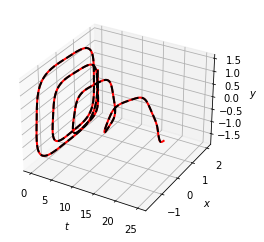

In [54]:
ax = plt.axes(projection='3d')
ax.plot(t_train, Xt_train_cubic[:, 0], Xt_train_cubic[:, 1], "r", label="$x_k$", **plot_kws)
ax.plot(t_train, Xt_Simulated_cubic[:, 0], Xt_Simulated_cubic[:, 1], "k--", label="model", **plot_kws)
ax.set(xlabel="$t$", ylabel="$x$", zlabel="$y$")